In [131]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, exposure

import rasterio
from rasterio.plot import show

import fiona
import rasterio.tools.mask
from rasterio.plot import show, reshape_as_image
from rasterio.warp import calculate_default_transform, reproject, RESAMPLING

In [18]:
cd ~/Downloads/LC80140322013079LGN03/

/Users/Gioia/Downloads/LC80140322013079LGN03


In [138]:
def reprojection(src_image):
    # This block of code will open a file (B10.TIF) and
    # reproject to another crs.
    dst_crs = 'EPSG:4326'

    affine, width, height = calculate_default_transform(
        src_image.crs, dst_crs, src_image.width, src_image.height, *src_image.bounds)
    kwargs = src_image.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': affine,
        'affine': affine,
        'width': width,
        'height': height
    })

    dst_image = rasterio.open('tmp-image.tif', 'w', **kwargs)

    reproject(
        source=rasterio.band(src_image, 1),
        destination=rasterio.band(dst_image, 1),
        src_transform=src.affine,
        src_crs=src.crs,
        dst_transform=affine,
        dst_crs=dst_crs,
        resampling=RESAMPLING.nearest)

    return dst_image

In [368]:
def color_image_show(img, title):
    """
    Show image
    Input:
    img - 3D array of uint16 type
    title - string
    """
    fig = plt.figure(figsize=(5, 5))
    fig.set_facecolor('white')
    plt.imshow(img/65535.0)
    plt.title(title)
    plt.show()

In [473]:
def get_thermal_const(n):
    """
    Get band thermal constants K1 and K2
    Input:
    n - integer in the range 10-11
    Output:
    Ks - list of two floats
    """
    if n in range(10, 12):
        n_str = str(n)
        s = 'K._CONSTANT_BAND_' + n_str + ' = '
        search_str = '(?<=' + s + ').*'
        
        fn = !ls *MTL.txt
    
        f = open(fn[0], 'r+')
        
        Ks = []
        for line in f:
            k = re.search(search_str, line)
            if k:
                Ks.append(float(k.group(0)))
    
        f.close()
    
        return Ks
    else:
        print('Band number has to be in the range 10-11!')
        
def get_gain_bias(n):
    """
    Get band radiance gain and bias
    Input:
    n - integer in the range 1-11
    Output:
    gain - float
    bias - float
    """
    if n in range(1, 12):
        n_str = str(n)
        s_g = 'RADIANCE_MULT_BAND_' + n_str + ' = '
        s_b = 'RADIANCE_ADD_BAND_' + n_str + ' = '
    
        fn = !ls *MTL.txt
    
        f = open(fn[0], 'r+')
    
        search_str_g = '(?<=' + s_g + ').*'
        search_str_b = '(?<=' + s_b + ').*'
    
        for line in f:
            s1 = re.search(search_str_g, line)
            s2 = re.search(search_str_b, line)
            if s1:
                gain = float(s1.group(0))
            elif s2:
                bias = float(s2.group(0))
    
        f.close()
    
        return gain, bias
    else:
        print('Band number has to be in the range 1-11!')        
        
def image_adjust_brightness(img, limit_left, limit_right, title):
    """
    Adjust image brightness and plot the image
    Input:
    img - 2D array of uint16 type
    limit_left - integer
    limit_right - integer
    title - string
    """
    img_ha = exposure.rescale_intensity(img, (limit_left, limit_right))
    
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    plt.imshow(img_ha, cmap='gray')
    plt.colorbar()
    plt.title(title)
    plt.show()    
    
def get_gain_bias_angle(n):
    """
    Get band reflectance gain, bias, 
    and Sun elevation angle
    Input:
    n - integer in the range 1-11
    Output:
    gain - float
    bias - float
    """
    if n in range(1, 10):
        n_str = str(n)
        s_g = 'REFLECTANCE_MULT_BAND_' + n_str + ' = '
        s_b = 'REFLECTANCE_ADD_BAND_' + n_str + ' = '
    
        fn = !ls *MTL.txt
    
        f = open(fn[0], 'r+')
    
        search_str_g = '(?<=' + s_g + ').*'
        search_str_b = '(?<=' + s_b + ').*'
        search_str_a = '(?<=' + 'SUN_ELEVATION = ' + ').*'
    
        for line in f:
            s0 = re.search(search_str_a, line)
            s1 = re.search(search_str_g, line)
            s2 = re.search(search_str_b, line)
            if s0:
                angle = float(s0.group(0))
            elif s1:
                gain = float(s1.group(0))
            elif s2:
                bias = float(s2.group(0))
    
        f.close()
    
        return gain, bias, angle
    else:
        print('Band number has to be in the range 1-9!')    

In [110]:
def subset(src_image, features):
    
    out_image, out_transform = rasterio.tools.mask.mask(src_image, features, crop=True)

    out_meta = src_image.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    return out_image

In [ ]:
fname = '/Users/Gioia/Projects/landfill-satellites/data/output/poly.shp'

# import the mask geometries 
with fiona.open(fname, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

## Read Band Red, NIR and TIRS

In [435]:
b10 = rasterio.open('B10.TIF')

# for NDVI calculation
b4 = rasterio.open('B4.TIF')
b5 = rasterio.open('B5.TIF')

In [436]:
# reproject GeoTiff in order to subset with other polygon
b10 = reprojection(b10)
#b4 = reprojection(b4)
#b5 = reprojection(b5)

In [440]:
b10a = b10.read(1)

In [468]:
test = b10a[2600:2800,5700:5900]

In [470]:
gain, bias = get_gain_bias(10)
Ks = get_thermal_const(10)
L  = gain * test + bias # Convert raw pixel readouts to spectral radiance
temp = Ks[1] / np.log(Ks[0] / L + 1)

In [475]:
temp.max()

291.65001078692632

In [476]:
temp.min()

270.13633900069402

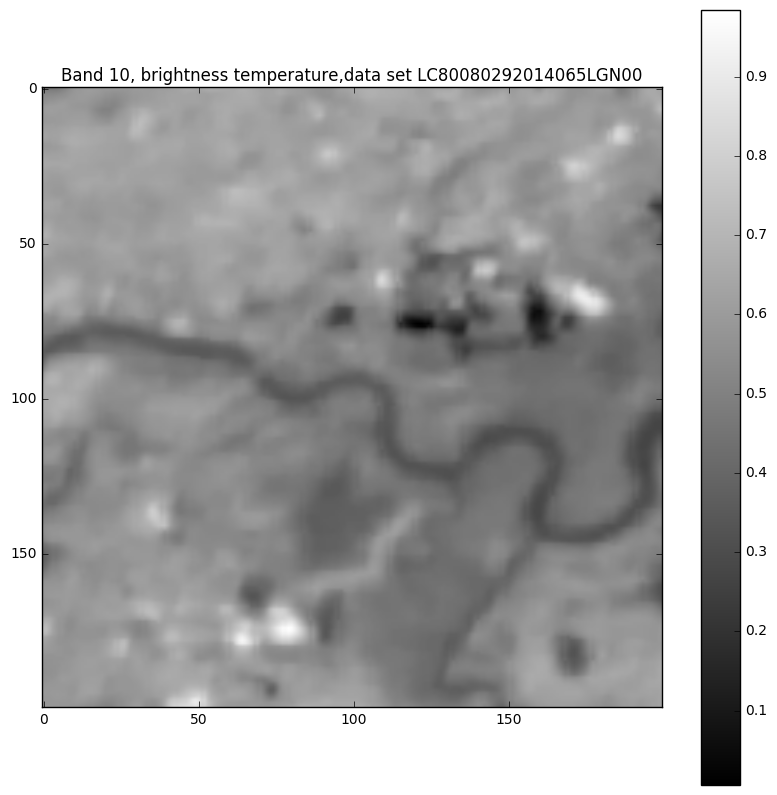

In [477]:
image_adjust_brightness(temp, 270, 292, 'Band 10, brightness temperature,'
                        'data set LC80080292014065LGN00')

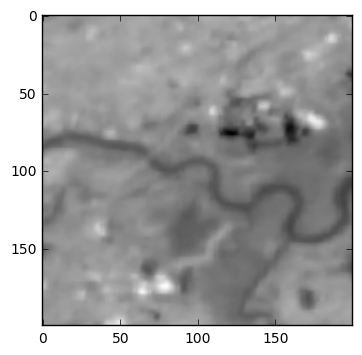

In [471]:
plt.imshow(temp, cmap='gray')
plt.show()

In [443]:
# subset based on a polygon 
b10b = subset(b10, features)[0,:-1,1:] # not sure why there are 0 values in soe of these
#b4 = subset(b4, features)
#b5 = subset(b5, features)

In [456]:
b10b.data

array([[20427, 20513, 20642, ..., 18767, 18999, 19267],
       [20122, 20204, 20306, ..., 19167, 19288, 19484],
       [19941, 19980, 20032, ..., 19556, 19638, 19752],
       ..., 
       [22487, 22418, 22418, ..., 21999, 22014, 22024],
       [22822, 22696, 22696, ..., 21965, 21979, 21994],
       [23230, 23000, 23000, ..., 21953, 21966, 21983]], dtype=uint16)

## Calculate NDVI

In [280]:
b4_gain, b4_bias, angle = get_gain_bias_angle(4)
b5_gain, b5_bias, angle = get_gain_bias_angle(5)

b4_lambda_refl  = (b4_gain * b4 + b4_bias) / np.sin(angle)
b5_lambda_refl  = (b5_gain * b5 + b5_bias) / np.sin(angle)

In [281]:
ndvi = (b5_lambda_refl - b4_lambda_refl) / (b5_lambda_refl + b4_lambda_refl)

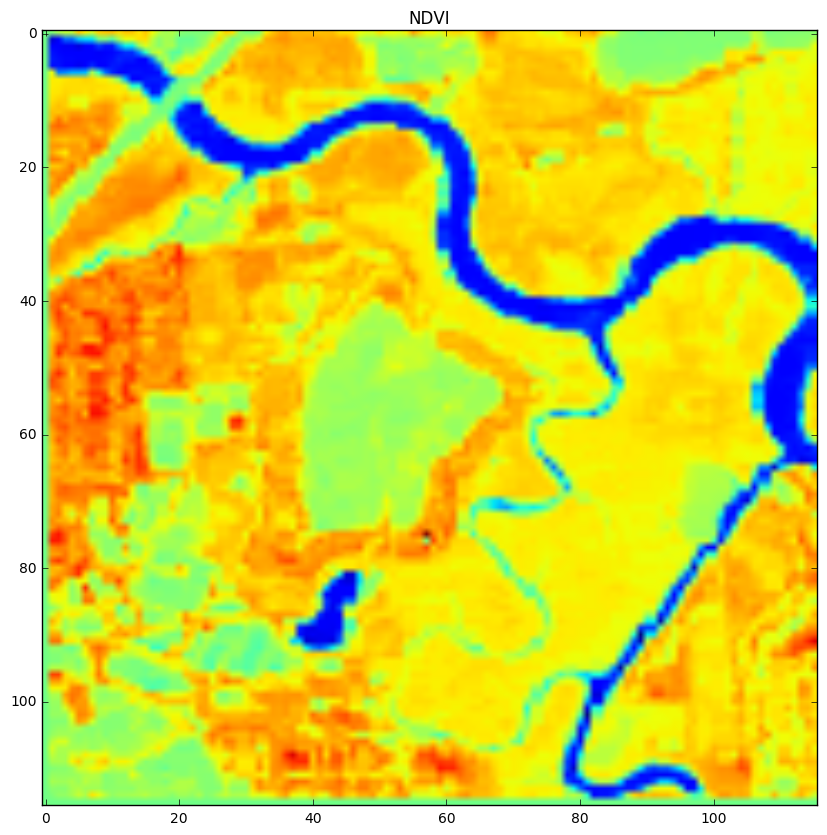

In [407]:
#show(ndvi)
fig = plt.figure(figsize=(10,10))
plt.imshow(ndvi.data[0])
plt.title('NDVI')
plt.savefig('/Users/Gioia/Desktop/ndvi.pdf', dpi=300, bbox_inches='tight')

## Calculate Emissivity

$\varepsilon_\lambda = \varepsilon{_v}{_\lambda} - ( \varepsilon{_v}{_\lambda} - \varepsilon{_s}{_\lambda})(\frac{NDVI - NDVI_v}{NDVI_s - NDVI_v})^2$

In [283]:
def emissivity(ndvi):
    soil_emiss = 0.96
    veg_emiss = 0.99
    NDVIv = 0.99 # max NDVI for full vegitation 
    NDVIs = 0.17 # min NDVI for bare soil
    
    return veg_emiss - (veg_emiss - soil_emiss) * ((ndvi - NDVIv) / (NDVIs - NDVIv))**2

In [284]:
epsilon = np.array([map(emissivity, i) for i in ndvi.data[0]])

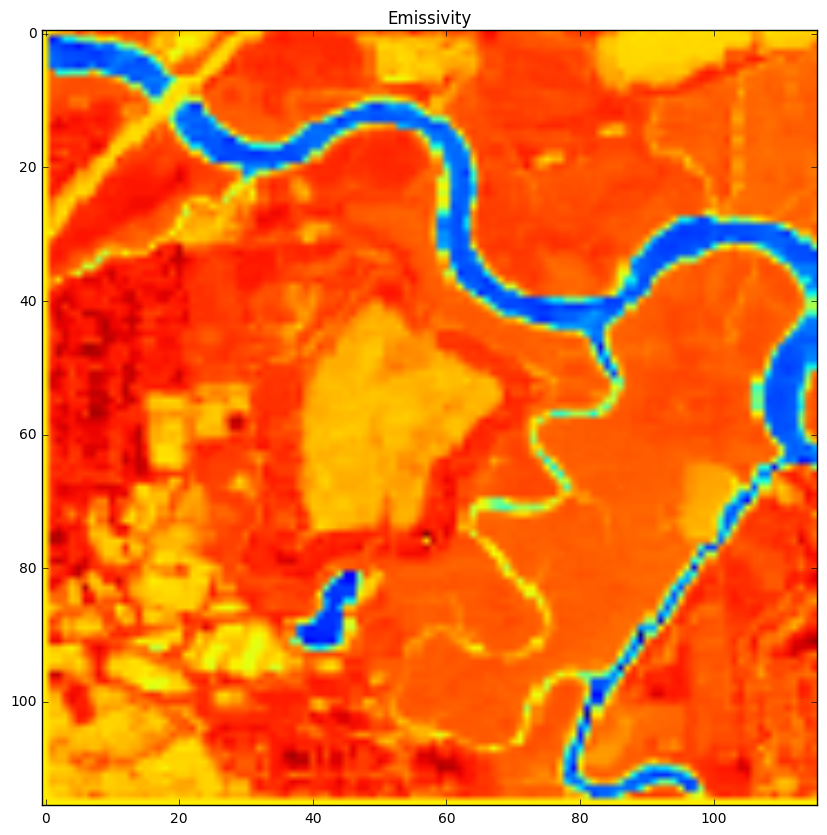

In [408]:
fig = plt.figure(figsize=(10,10))
plt.imshow(epsilon)
plt.title('Emissivity')
plt.savefig('/Users/Gioia/Desktop/emissivity.pdf', dpi=300, bbox_inches='tight')

## Calculate Brightness Temperature

$T_b = K_2 / (\ln(K_1/L_b + 1)$

In [414]:
pwd

u'/Users/Gioia/Downloads/LC80140322013079LGN03'

In [433]:
gain, bias = get_gain_bias(10)
print "Gain {0}\nBias {1}".format(gain, bias)
Ks = get_thermal_const(10)
L  = gain * b10.data + bias # Convert raw pixel readouts to spectral radiance
Tb = Ks[1] / np.log(Ks[0] / L + 1)

Gain 0.0003342
Bias 0.1


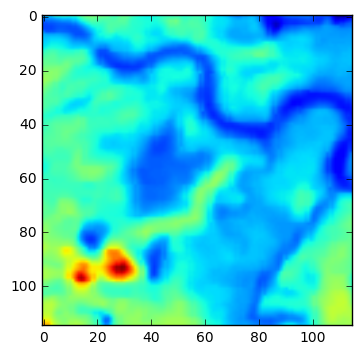

In [432]:
show(Tb)

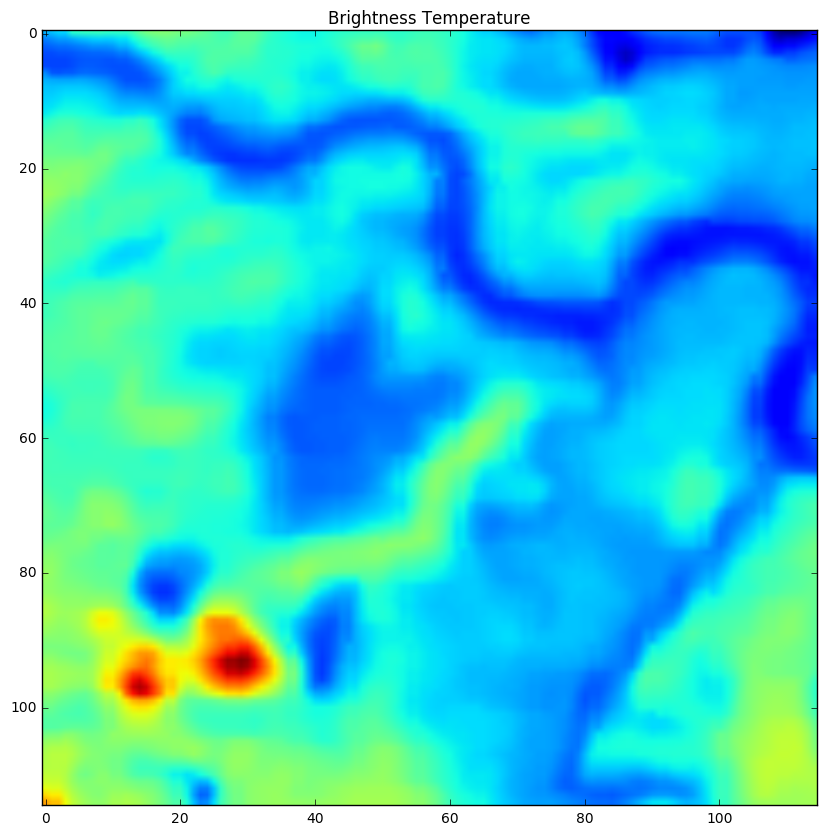

In [409]:
fig = plt.figure(figsize=(10,10))
plt.imshow(Tb)
plt.title('Brightness Temperature')
plt.savefig('/Users/Gioia/Desktop/brightness_temp.pdf', dpi=300, bbox_inches='tight')

## Calculate Land Surface Temperature

$T_s = T_b / (1 + (\lambda * T_b/\alpha) * \ln\varepsilon)$

In [287]:
l = 10.895
a = 14388.15
Ts = Tb / (1+(l*Tb/a) * np.log(epsilon[1:,1:]))

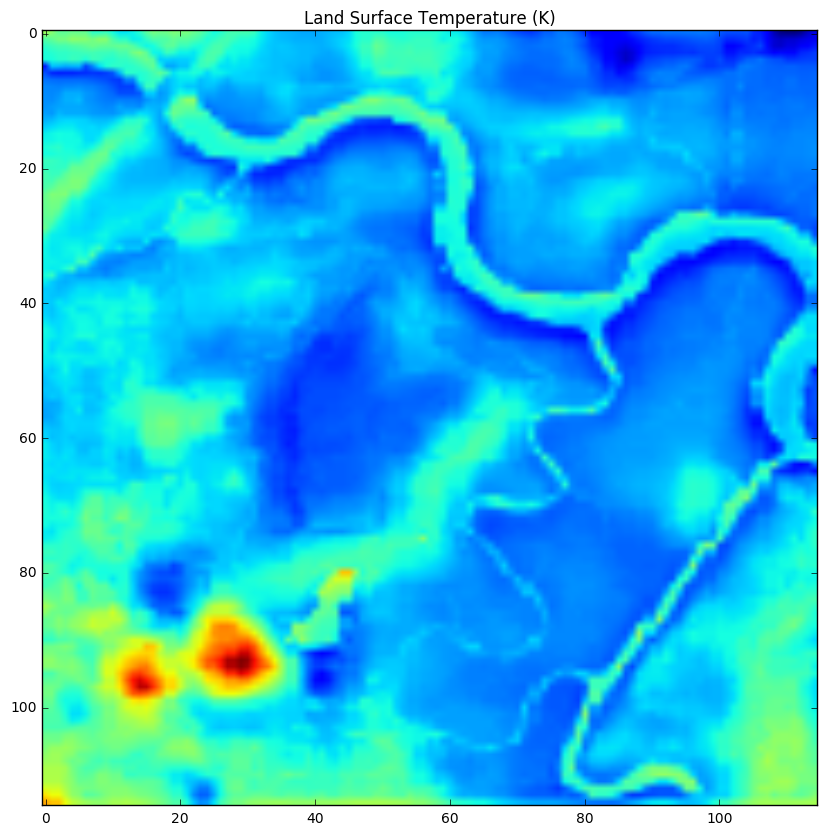

In [410]:
#show(ndvi)
fig = plt.figure(figsize=(10,10))
plt.imshow(Ts)
plt.title('Land Surface Temperature (K)')
plt.savefig('/Users/Gioia/Desktop/lst-k.pdf', dpi=300, bbox_inches='tight')

## Convert Kelvin to C

In [289]:
T = Ts - 273.15

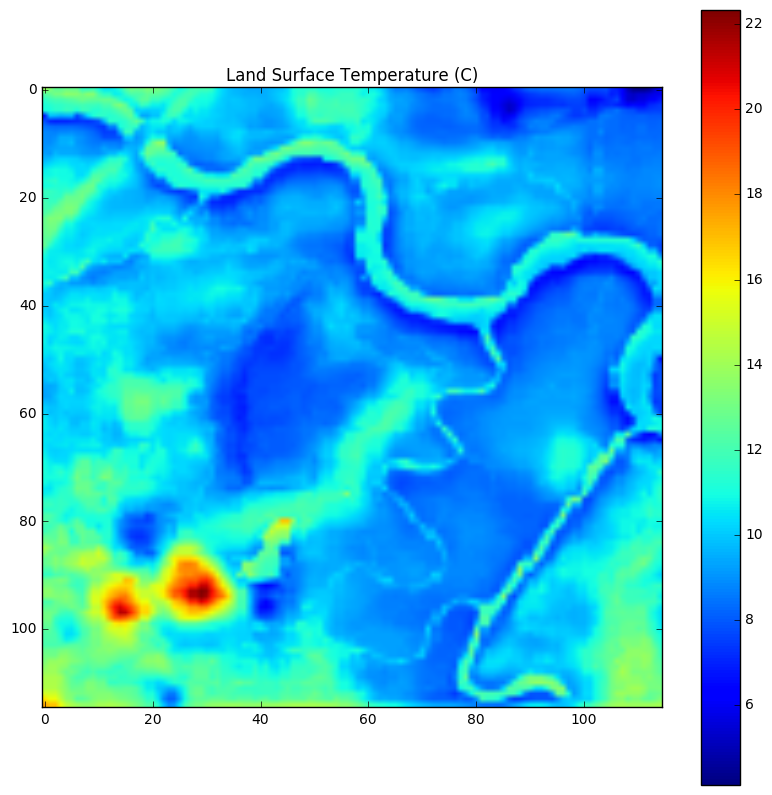

In [411]:
fig = plt.figure(figsize=(10,10))
plt.imshow(T, cmap='jet')
plt.colorbar()
plt.title('Land Surface Temperature (C)')
plt.savefig('/Users/Gioia/Desktop/lst-c.pdf', dpi=300, bbox_inches='tight')

---